<center>
    <h1> Extended Project Supplement</h1>
</center>

Interactive plots + animations corresponding to figures
- Code for all figures??
- Numerical Methods 
- Application to model
- Space homogeneity
- Space inhomogeneity
- Python .py file too?


In [2]:
import numpy as np
from numpy.random import normal, uniform
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
sns.set()
sns.color_palette('colorblind')
cmap = plt.get_cmap('plasma')

from FinalCode import plotting_tools as animplt
from FinalCode import herding as herd
from FinalCode import ToyProblems as TP
from FinalCode import SpaceHom as hom

savepath = './Report/Figures/'
save = False

## Toy Problems

- Heat eqn, adv eqn
- Mesh refinement error
- OU particles

### Heat Equation

Solving the heat equation using finite differences. To see the sensitivity of FTCS on mesh size, try violating the stability condition $\frac{\sigma \Delta t}{\Delta x}^2 < \frac{1}{2}$. For example, set `diffusion = 1, timestep = 0.01, spacestep = 0.1`

In [ ]:
%matplotlib inline
diffusion = 1
timestep = 0.005
spacestep = 0.1
T_final = 5
domain_size = 5
def indicator(x): return np.array([int(i>=-1 and i<=0) for i in x])
def gaussian(x): return stats.norm.pdf(x, loc=0, scale=1)

initial_data = gaussian
diff_solvers = [TP.FTCS, TP.BTCS, TP.CN]

###############################################################################
fig, ax = plt.subplots(len(diff_solvers), 1, figsize=(10,10))
#fig.suptitle('Heat Equation in 1D', fontsize=16)
if len(diff_solvers)>1:
    for idx, solver in enumerate(diff_solvers):
        x, sol = TP.solve_heat_eqn(solver=solver, dt=timestep, dx=spacestep,
                                T_end=T_final, L=domain_size, initial_dist=initial_data)
        ax[idx].set_prop_cycle(color=[cmap(k) for k in np.linspace(1, 0, 10)])
        ax[idx].set_title(solver.__name__, fontsize=14)
        ax[idx].set_xlabel(r'$x$', fontsize=18)
        ax[idx].set_ylabel(r'$u$', fontsize=18)
        for i in np.logspace(0, np.log10(len(sol[:,0])-1), num=10):
            ax[idx].plot(x, sol[int(i),])

else:
    solver = diff_solvers[0]
    x, sol = TP.solve_heat_eqn(solver=solver, D=diffusion, dt=timestep,
                               dx=spacestep, T_end=T_final, L=domain_size)
    ax.set_prop_cycle(color=[cmap(k) for k in np.linspace(1, 0, 10)])
    ax.set_title(solver.__name__, fontsize=14)
    ax.set_xlabel(r'$x$', fontsize=16)
    ax.set_ylabel(r'$u$', fontsize=16)
    for i in np.logspace(0, np.log10(len(sol[:,0])-1), num=10):
        ax.plot(x, sol[int(i),])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

if save:
    plt.savefig(savepath+'{}.eps'.format(timestep), format='eps', dpi=1000)

### Advection Equation

Solving the advection equation using finite differences and finite volumes. Both methods are sensitive to mesh spacing. For example, set `wavespeed = 1, timestep = 0.21, spacestep = 0.1`. Also note the artificial dispersion introduced, regardless of spacing.

In [ ]:
wavespeed = 0.5
T_final = 3
timestep = 0.01
spacestep = 0.1
domain_size = 5 
def indicator(x): return np.array([int(i>=-1 and i<=0) for i in x])
def gaussian(x): return stats.norm.pdf(x, loc=0, scale=1)
initial_data = indicator
adv_solvers = [TP.upwind]#, TP.FV_upwind]


###############################################################################
fig, ax = plt.subplots(len(adv_solvers), 1, figsize=(10,10))
#fig.suptitle('Advection Equation in 1D', fontsize=16)
cmap = plt.get_cmap('plasma')
if len(adv_solvers)>1:
    for idx, solver in enumerate(adv_solvers):
        adv_x, adv_sol = TP.solve_adv_eqn(solver=solver, a=wavespeed,
                                          dt=timestep, dx=spacestep,
                                          T_end=T_final, L=domain_size,
                                          initial_dist=initial_data)
        ax[idx].set_title(solver.__name__, fontsize=14)
        ax[idx].set_xlabel(r'$x$', fontsize=14)
        ax[idx].set_ylabel(r'$u$', fontsize=14)
        ax[idx].set_prop_cycle(color=[cmap(k) for k in np.linspace(1, 0, 10)])
        for i in np.logspace(0, np.log10(np.size(adv_sol, axis=0)-1), num=10):
            ax[idx].plot(adv_x, adv_sol[int(i),])
else:
    solver = adv_solvers[0]
    adv_x, adv_sol = TP.solve_adv_eqn(solver=solver, a=wavespeed,
                                      dt=timestep, dx=spacestep,
                                      T_end=T_final, L=domain_size,
                                      initial_dist=initial_data)
    ax.set_title(solver.__name__, fontsize=14)
    ax.set_xlabel(r'$x$', fontsize=14)
    ax.set_ylabel(r'$u$', fontsize=14)
    ax.set_prop_cycle(color=[cmap(k) for k in np.linspace(1, 0, 10)])
    for i in np.logspace(0, np.log10(np.size(adv_sol, axis=0)-1), num=10):
        ax.plot(adv_x, adv_sol[int(i),])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

if save:
    plt.savefig(savepath+'adv'+initial_data.__name__+'.eps', format='eps', dpi=1000)

### Particle System with Langevin Dynamics


Outputs an animation of histogram of particles at each timestep. Along with the mean velocity and variance of all particles at each timestep.

In [ ]:
%matplotlib qt
particle_count = 1000
diffusion = 1
initial_data = uniform(low=2, high=4, size=particle_count)
timestep = 0.01
T_final = 5

#If animation is too slow, increase framstep.
framestep = 1
###############################################################################
t, v, [m1, var] = TP.run_OU_process(particles=particle_count,
                   D=diffusion,
                   initial_dist=initial_data,
                   dt=timestep,
                   T_end=T_final)

fig, ax = plt.subplots(1, 2, figsize=(16,8))
vel_ax = ax[0]
mom_ax = ax[1]
n_v, bins_v, patches_v = vel_ax.hist(v[0,], bins=np.arange(v.min(), v.max(), 0.15),
                                         density=True, label='Position')

mu = 0
sigma = np.sqrt(diffusion)
_v = np.arange(mu - 5*sigma, mu + 5*sigma, 0.01)
stat_dist = stats.norm.pdf(_v, mu, sigma)

vel_ax.plot(_v, stat_dist, label=r'Stationary D$^{\mathrm{n}}$')

mean = np.zeros(len(v))
var = np.zeros(len(v))
for i in range(len(v)):
    mean[i] = np.mean(v[i])
    var[i] = np.var(v[i])

line_mean, = mom_ax.plot(t, mean, label="Mean")
line_var, = mom_ax.plot(t, var, label="Variance")
mom_ax.legend(loc='upper right')
mom_ax.set_xlabel('Time', fontsize=20)
mom_ax.plot([0, T_final], [0, 0], 'b--')
mom_ax.plot([0, T_final], [diffusion, diffusion],'r--')

vel_ax.set_ylim(0, max(stat_dist.max(),n_v.max())+0.1)
vel_ax.set_xlim(v.min(), v.max())
vel_ax.set_xlabel('Position', fontsize=20)
vel_ax.set_ylabel('Density', fontsize=20)
def animate(i,framestep): 
        line_mean.set_data(t[:(i*framestep)],mean[:(i*framestep)])
        line_var.set_data(t[:(i*framestep)], var[:(i*framestep)])
        n_v, _ = np.histogram(v[i*framestep,],
                              bins=np.arange(v.min(), v.max(), 0.15),
                              density=True)
        for rect_v, height_v in zip(patches_v, n_v):
              rect_v.set_height(height_v)
        fig.suptitle('t = {:.2f}'.format(t[i*framestep]), fontsize=20)
        fig.show()

ani = animation.FuncAnimation(fig, lambda i: animate(i, framestep), interval=60,
                              frames=len(t)//framestep, repeat=False)
plt.show()

In [ ]:
%matplotlib inline
T_final = 100
t, v, [m1, var] = TP.run_OU_process(particles=particle_count,
                   D=diffusion,
                   initial_dist=initial_data,
                   dt=timestep,
                   T_end=T_final)

fig, ax = plt.subplots(1,2, figsize=(16,8))
n_v, bins_v, patches_v = ax[0].hist(v[-750:].flatten(), bins=np.arange(v.min(), v.max(), 0.15),
                                         density=True, label='Position')
ax[0].plot(_v, stat_dist, 'r--')
ax[0].set_xlabel('Position', fontsize=18)
ax[0].set_ylabel('Density', fontsize=18)
for _ in range(3):
    ax[1].plot(t[:500], v[:500,_], label='Particle {}'.format(_+1))
ax[1].set_xlabel('Time', fontsize=18)
ax[1].set_ylabel('Position', fontsize=18)
fig.show()
if save:
    fig.savefig(savepath+'OUparticletraj.eps', format='eps', dpi=1000)


## Particle Model Simulation

OU process is same as space homogeneous with no interaction. Combine 
Interaction, histograms 

switch! In space?


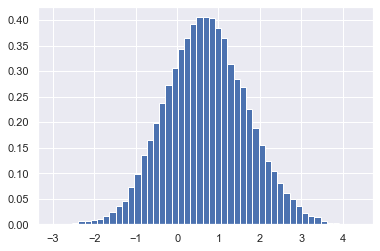

In [5]:
particle_count = 100
diffusion = 1
initial_data = uniform(size=100)
timestep = 0.01
T_final = 10
herding_function = herd.smooth_G

t, v, [M1, var] = hom.run_particle_model(particles=particle_count,
                   D=diffusion,
                   initial_dist=initial_data,
                   dt=timestep,
                   T_end=T_final,
                   G=herding_function)

n, bins, patches = plt.hist(v.flatten(), bins=np.arange(v.min(), v.max(), 0.15),
                           density=True, label='Velocity')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(16,8))
vel_ax = ax[0]
mom_ax = ax[1]
n_v, bins_v, patches_v = vel_ax.hist(v[0,], bins=np.arange(v.min(), v.max(), 0.15),
                                         density=True, label='Position')

mu = 1
sigma = np.sqrt(diffusion)
_v = np.arange(mu - 5*sigma, mu + 5*sigma, 0.01)
stat_dist = stats.norm.pdf(_v, mu, sigma)

ax.plot(_v, stat_dist, label=r'Stationary D$^{\mathrm{n}}$')
ax.set_ylim(0, max(stat_dist.max(),n_v.max())+0.1)
ax.set_xlim(v.min(), v.max())
ax.set_xlabel('Position', fontsize=20)
ax.set_ylabel('Density', fontsize=20)
def animate(i,framestep): 
      n_v, _ = np.histogram(v[i*framestep,],
                              bins=np.arange(v.min(), v.max(), 0.15),
                              density=True)
        for rect_v, height_v in zip(patches_v, n_v):
              rect_v.set_height(height_v)
        fig.suptitle('t = {:.2f}'.format(t[i*framestep]), fontsize=20)
        fig.show()

framestep = 1
ani = animation.FuncAnimation(fig, lambda i: animate(i, framestep), interval=60,
                              frames=len(t)//framestep, repeat=False)
plt.show()

## PDE Simulation
- FD
- Space hom show agreement with particle model in histogram
- Exponential Convergence of moments
- Long time L1 error, asymmetry
- FV method
- agreement in histogram, visual with FD
- symmetric error
- Mesh refinement errors
- 


## Space Het Particle Model
Visual switch